In [6]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import tsam.timeseriesaggregation as tsam
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

sys.path.insert(1, '/media/pklein/SATA_SSD/GitHub/pypsa_utilities/eskom data/')
sys.path.insert(1, '/mnt/wsl/PHYSICALDRIVE0p1/GitHub/pypsa_utilities/eskom data/')

import data_utilities as du
import plotting_utilities as pu
import financial_utilities as fu
import xarray as xr
import cartopy.crs as ccrs
from pypsa.descriptors import get_switchable_as_dense as get_as_dense
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np
from shapely.geometry import shape
import rioxarray
import atlite
import shapely
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning) 

from pypsa.descriptors import (
    Dict,
    additional_linkports,
    expand_series,
    get_active_assets,
    get_activity_mask,
    get_bounds_pu,
    get_extendable_i,
    get_non_extendable_i,
    nominal_attrs,
)

%run ../scripts/_helpers.py

In [7]:
eskom_data = du.eskom_data('../data/ESK3272.csv')

In [22]:
result= pd.DataFrame(0,index=range(2019,2024),columns=['coal','wind','solar_pv','solar_csp','other_re'])
for tech in result.columns:
    for y in range(2019,2024):
        result.loc[y,tech]=eskom_data[tech+'_installed'].loc[str(y)][-1]-eskom_data[tech+'_installed'].loc[str(y)][0]


In [35]:
tech='solar_pv'
eskom_data[tech+'_installed'].loc['2021']

2212-2107

105

In [10]:
eskom_data['coal_installed'].groupby(eskom_data.index.year).max()

Date Time Hour Beginning
2018    36953.0
2019    37424.0
2020    38053.0
2021    39456.0
2022    39927.0
2023    39093.0
Name: coal_installed, dtype: float64

In [16]:
eskom_data['other_re_installed'].groupby(eskom_data.index.year).max()

Date Time Hour Beginning
2018    21.78
2019    21.78
2020    21.78
2021    25.58
2022    50.58
2023    50.58
Name: other_re_installed, dtype: float64

In [10]:
3442.57-3023.37

419.2000000000003

In [17]:
eskom_data['other_re'].groupby(eskom_data.index.year).max()

Date Time Hour Beginning
2018    19.513
2019    17.935
2020    18.206
2021    21.777
2022    47.553
2023    47.836
Name: other_re, dtype: float64

In [14]:
eskom_data['solar_csp'].groupby(eskom_data.index.year).max()

Date Time Hour Beginning
2018    399.691
2019    502.098
2020    504.514
2021    504.935
2022    506.249
2023    488.028
Name: solar_csp, dtype: float64

In [2]:
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.style.use('Meridian.mplstyle')

In [3]:
colour_map={'onwind':'#77D1E4',
            'onwind_100MW':'#2eb8d6',
            'solar':'#FFBB4E',
            'solar_pv_1MW':'#FBDC81',
            'solar_pv_100MW':'#F99B00',
            'CSP':'#feed82',
            'battery':'#cba3cb',
            'bat_c':'#AA68AA',#CBA3CB
            'bat_d':'#AA68AA',
            'PHS':'#873f91',
            'phs_c':'#873f91',
            'phs_d':'#873f91',
            'coal':'#3C3C3C',
            'hydro':'#004F95',
            'hydro-import':'#004F95',
            'other':'#004F95',
            'ocgt':'#8D7867',
            'diesel':'#8D7867',
            'gas':'#8D7867',
            'OCGT':'#8D7867',
            'CCGT':'#ffa69e',
            'rmippp':'#51969B',
            'biomass':'#8C9A07',
            'nuclear':'#C84936',
            'demand_response':'#817E80',
            'loadshedding':'#DE9287'}

In [197]:
n = pypsa.Network('../results/networks/solved_val-2Gt-UNC_RSA_redz_lcopt_Co2L.nc')

INFO:pypsa.io:Imported network solved_val-2Gt-UNC_RSA_redz_lcopt_Co2L.nc has buses, carriers, generators, global_constraints, loads, storage_units


In [235]:
cap = aggregate_capacity(n)/1000
en = aggregate_energy(n)/1e6

cap.loc['hydro',:] = cap.loc['hydro',:]+cap.loc['hydro-import',:]
en.loc['hydro',:] = en.loc['hydro',:]+en.loc['hydro-import',:]

cap.loc['other',:]=cap.loc['hydro',:]+cap.loc['biomass',:]
en.loc['other',:]=en.loc['hydro',:]+en.loc['biomass',:]

cap = cap.drop(['load_shedding','hydro-import'])
en = en.drop(['load_shedding','hydro-import'])

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/pypsa/descriptors.py:371: FutureWarning:

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/pypsa/descriptors.py:371: FutureWarning:

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/pypsa/descriptors.py:371: FutureWarning:

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/pypsa/descriptors.py:371: FutureWarning:

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.

/home/pklein/anaconda3/envs/pypsa-eur/lib/python3.10/site-packages/pypsa/descriptors.py:371: FutureWarning:

In a future version of pandas all arguments of DataFrame.an

In [214]:
scenario ='2Gt_UNC'
csir_cap = pd.read_excel(
    '../data/ambitions_validation.xlsx',
    sheet_name = 'capacity_CSIR_'+scenario,
    index_col=0
)/1000

csir_en = pd.read_excel(
    '../data/ambitions_validation.xlsx',
    sheet_name = 'energy_CSIR_'+scenario,
    index_col=0
)/1000
csir_cap['other']=csir_cap['hydro']+csir_cap['biomass']
csir_en['other']=csir_en['hydro']+csir_en['biomass']

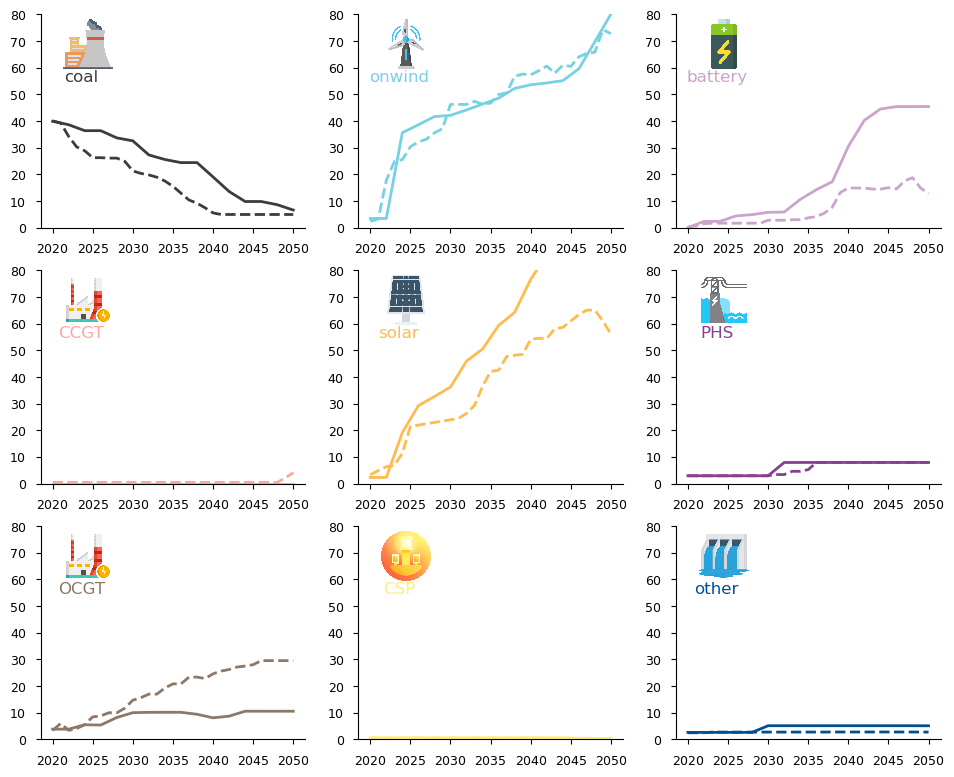

In [215]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
y_max = 80
linewidth=2

technologies = ['coal', 'CCGT', 'OCGT', 'onwind', 'solar', 'CSP', 'battery', 'PHS', 'other']

BL_img = (0.18,0.2)
TL_img = (0.18,0.86)

BL_txt = (0.18,0.08)
TL_txt = (0.18,0.74)

img_coords = {
                'coal':TL_img,
                'CCGT':TL_img,
                'OCGT':TL_img,
                'onwind':TL_img,
                'solar':TL_img,
                'CSP':TL_img,
                'battery':TL_img,
                'PHS':TL_img,
                'other':TL_img,
}
txt_coords = {
                'coal':TL_txt,
                'CCGT':TL_txt,
                'OCGT':TL_txt,
                'onwind':TL_txt,
                'solar':TL_txt,
                'CSP':TL_txt,
                'battery':TL_txt,
                'PHS':TL_txt,
                'other':TL_txt,
}

row = 0
col = 0

for tech in technologies:
    ax = axs[row, col]
    img = mpimg.imread('../../icons/'+tech+'.png')
    cap.loc[tech,:].plot(kind='line', ax=axs[row, col], ylim=([0,y_max]), color=colour_map[tech], linewidth=linewidth)
    csir_cap[tech].plot(kind='line', ax=axs[row, col], xlabel='', color=colour_map[tech], linestyle='--', linewidth=linewidth)
    
    # Increment the row and column counters
    row += 1
    if row > 2:
        row = 0
        col += 1

    # Create an OffsetImage and AnnotationBbox
    imagebox = OffsetImage(img, zoom=0.07)
    ab = AnnotationBbox(imagebox, img_coords[tech], xycoords='axes fraction', frameon=False)
    
    # Add the AnnotationBbox to the plot
    ax.add_artist(ab)
    annotation=ax.annotate(tech, xy=txt_coords[tech], xycoords='axes fraction', fontsize=12,
            xytext=(-5, -5), textcoords='offset points', ha='center', va='center',
            color=colour_map[tech])

    annotation.set_fontfamily('sans-serif')

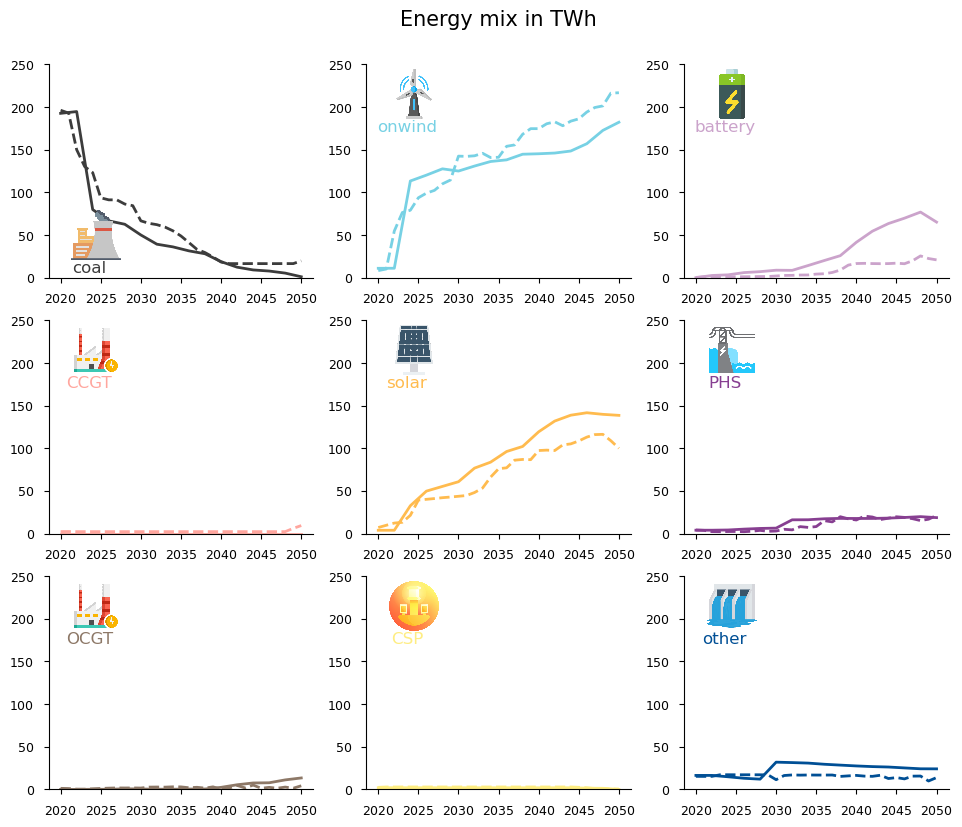

In [216]:
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
y_max = 250
linewidth=2

technologies = ['coal', 'CCGT', 'OCGT', 'onwind', 'solar', 'CSP', 'battery', 'PHS', 'other']

BL_img = (0.18,0.2)
TL_img = (0.18,0.86)

BL_txt = (0.18,0.08)
TL_txt = (0.18,0.74)

img_coords['coal'] = BL_img
txt_coords['coal'] = BL_txt

row = 0
col = 0

for tech in technologies:
    ax = axs[row, col]
    img = mpimg.imread('../../icons/'+tech+'.png')
    en.loc[tech,:].plot(kind='line', ax=ax, color=colour_map[tech], linewidth=linewidth)
    csir_en[tech].plot(kind='line', ax=ax, color=colour_map[tech], linestyle='--', linewidth=linewidth)
    
    ax.set_ylim([0,y_max])
    ax.set_xlabel('')

    # Increment the row and column counters
    row += 1
    if row > 2:
        row = 0
        col += 1

    # Create an OffsetImage and AnnotationBbox
    imagebox = OffsetImage(img, zoom=0.07)
    ab = AnnotationBbox(imagebox, img_coords[tech], xycoords='axes fraction', frameon=False)
    
    # Add the AnnotationBbox to the plot
    ax.add_artist(ab)
    ax.annotate(tech, xy=txt_coords[tech], xycoords='axes fraction', fontsize=12,
            xytext=(-5, -5), textcoords='offset points', ha='center', va='center',
            color=colour_map[tech])

fig. suptitle("Energy mix in TWh", fontsize=15, y=0.93)

fig.savefig('validation_capacity', dpi=150, bbox_inches='tight')

In [213]:
period_weighting = n.investment_period_weightings["years"]
weightings = n.snapshot_weightings.mul(period_weighting, level=0, axis=0).loc[
    n.snapshots
]
em_pu = n.generators.carrier.map(n.carriers.co2_emissions)
em_pu = (
    weightings["generators"].to_frame("weightings")
    @ em_pu.to_frame("weightings").T
)
emissions = em_pu.mul(n.generators_t.p/n.generators.efficiency).groupby(n.generators_t.p.index.get_level_values(0)).sum().sum(axis=1)
emissions

period
2020    4.548762e+08
2022    4.647957e+08
2024    1.812840e+08
2026    1.509428e+08
2028    1.425151e+08
2030    1.126236e+08
2032    8.654949e+07
2034    7.920316e+07
2036    6.881073e+07
2038    6.133156e+07
2040    4.288153e+07
2042    3.185420e+07
2044    2.711910e+07
2046    2.469798e+07
2048    2.418648e+07
2050    4.632832e+07
dtype: float64

In [236]:
cap = cap.drop('other')
en = en.drop('other')

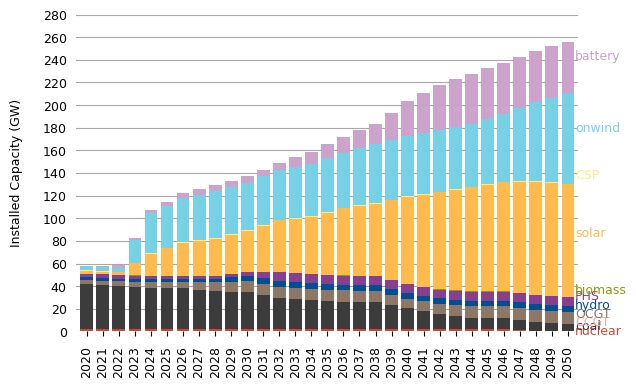

In [271]:
cap = cap.reindex(['nuclear','coal','CCGT','OCGT','hydro','PHS','biomass','solar','CSP','onwind','battery'])
ax = cap.T.plot.bar(stacked=True,color=colour_map,width=0.8,zorder=2)
plt.grid(axis='y', color='darkgray',linestyle='-',zorder=1)  # add light grey horizontal grid lines only

plt.ylabel('Installed Capacity (GW)')
plt.xlabel("")
plt.ylim([0,280])
plt.yticks(range(0, 280+1, 20))  # set y-axis ticks to increments of 20
ax.yaxis.set_tick_params(which='both',length=0)

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

cnt=0
height = 0     
dy = 1  # adjust this value to fine-tune the vertical spacing between annotations
for bar in ax.containers:
    end_cap = (cap).iloc[cnt,-1]
    x = len(cap.T)-1
    y = end_cap/2+height+dy*cnt  # adjust y position based on index of the bar
    ax.annotate(
        cap.index[cnt],
        xy=(x, y),
        xytext=(5, 0),
        textcoords="offset points",
        va="center",
        color=ax.containers[cnt][-1].get_facecolor(),
        #arrowprops=dict(arrowstyle='-', connectionstyle='angle3,angleA=0,angleB=-90', facecolor='black', width=1, headwidth=4, headlength=4),  # change arrow to line
    )
    height += end_cap
    cnt+=1

ax.legend().set_visible(False)



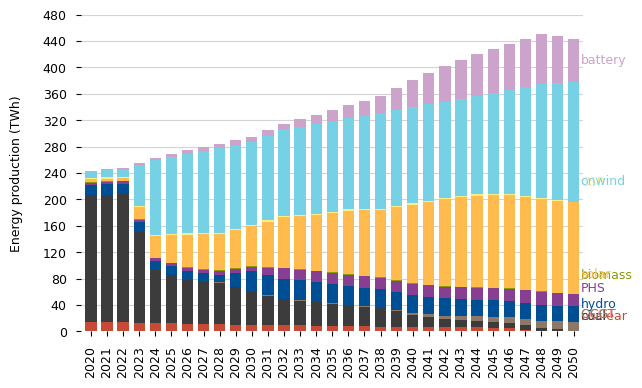

In [273]:
en = en.reindex(['nuclear','coal','CCGT','OCGT','hydro','PHS','biomass','solar','CSP','onwind','battery'])
ax = (en).T.plot.bar(stacked=True,color=colour_map,width=0.7,zorder=2)
ax.grid(axis='y', color='lightgray',linestyle='-',zorder=1)  # add light grey horizontal grid lines only
plt.ylabel('Energy production (TWh)')
plt.xlabel("")
plt.yticks(range(0, 480+1, 40))  # set y-axis ticks to increments of 20

for spine in ax.spines:
    ax.spines[spine].set_visible(False)

cnt=0
height = 0     
dy = 1  # adjust this value to fine-tune the vertical spacing between annotations
for bar in ax.containers:
    end_en = (en).iloc[cnt,-1]
    x = len(en.T)-1
    y = end_cap/2+height+dy*cnt  # adjust y position based on index of the bar
    ax.annotate(
        en.index[cnt],
        xy=(x, y),
        xytext=(5, 0),
        textcoords="offset points",
        va="center",
        color=ax.containers[cnt][-1].get_facecolor(),
        #arrowprops=dict(arrowstyle='-', connectionstyle='angle3,angleA=0,angleB=-90', facecolor='black', width=1, headwidth=4, headlength=4),  # change arrow to line
    )
    height += end_en
    cnt+=1

ax.legend().set_visible(False)



In [243]:
en

,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
nuclear,13.568320,13.568323,13.568326,13.217387,12.866448,12.377136,11.887823,11.434589,10.981356,10.350010,...,6.367108,6.208443,6.104656,6.000869,5.787652,5.574435,2.787218,0.000000,0.000000,0.000000
coal,192.644190,193.681169,194.718148,137.268940,79.819732,73.208795,66.597857,64.598814,62.599770,56.326285,...,15.530123,12.278247,10.666410,9.054573,8.401353,7.748133,6.540977,5.333820,3.187168,1.040516
CCGT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
OCGT,0.000000,0.000000,0.000000,0.085562,0.171124,0.159142,0.147160,0.456330,0.765501,0.630641,...,3.935205,5.447929,6.499394,7.550860,7.672366,7.793871,9.481117,11.168362,12.300563,13.432765
hydro,15.448759,15.452803,15.456846,14.668572,13.880298,13.013016,12.145735,11.656838,11.167941,21.137974,...,26.411737,26.027295,25.785367,25.543440,25.024718,24.505995,24.013776,23.521557,23.528622,23.535686
PHS,3.907293,3.903745,3.900198,4.031635,4.163072,4.670760,5.178448,5.573445,5.968443,6.157917,...,17.678525,17.705187,17.898274,18.091360,18.455916,18.820472,19.308775,19.797078,19.229180,18.661283
biomass,0.956613,0.956618,0.956623,0.947773,0.938923,0.926593,0.914262,0.899266,0.884271,0.865448,...,0.728892,0.722502,0.718391,0.714279,0.706701,0.699122,0.680331,0.661540,0.614703,0.567865
solar,3.821679,3.834508,3.847337,18.224632,32.601927,41.160694,49.719461,52.481612,55.243762,57.988282,...,125.582787,131.869632,135.306573,138.743514,140.174170,141.604827,140.677025,139.749223,139.151570,138.553918
CSP,1.986264,1.986269,1.986273,1.984557,1.982841,1.980727,1.978613,1.976397,1.974180,1.971842,...,1.954960,1.954372,1.953859,1.953347,1.708716,1.464085,1.381619,1.299154,0.649577,0.000000
onwind,10.956078,10.987323,11.018568,62.172913,113.327258,116.755648,120.184038,123.880166,127.576294,126.275440,...,145.670289,146.089052,147.274122,148.459192,152.753858,157.048523,164.847950,172.647378,177.428931,182.210484
